# Character Level RNN(LSTM) - Name generator - PyTorch

In this network we will train a LSTM(Long short-term memory) RNN(Recurrent Neural Network) with PyTorch. The network will train character by character on some text(i.e) list of names in this scenario, then generate new text character by character. **This model will be able to generate new text based on the text from the input!**

- To run this notebook once downloaded, please make you download the zip file that is attached to the submission. This zip file contains datapreprocesser file (which is referenced in this notebook to preprocess data), data folder with sample input data and a html version of this notebook 

Below are the steps at a higher level:
>1. Install the required packages
2. Import the packages
3. Loading and preprocessing the data
4. Define the LSTM model
5. Train the model
6. Test the trained model

## 1. Install the required packages

For the PIP install of any missing libraries the user shall add pip --trusted-resources or disconnect from corporate VPN, otherwise the user will not be able to install missing libraries.

For local testing with no CUDA access, the user should run the following command
- **pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html**

In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install tqdm
!pip install -U matplotlib
!pip install pandas
!pip install numpy
!pip install unidecode
!pip install regex
!pip install --upgrade pandas

## 2. Import the packages

Make sure to install all the packages 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [torch](http://pytorch.org) is a library for Python programs that facilitates building deep learning projects.
- [tqdm](https://tqdm.github.io/) is a packge for progress bars with Python. 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook, tqdm
import numpy as np
import pandas as pd
import datapreprocessor

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 3. Loading and preprocessing the data

First up, we need to get our dataset. 

Our dataset is of csv format. Read the csv file using pandas. Turn the unicode string into plain ASCII. Convert to lower case, trim and remove non-letter characters.

In [2]:
#read the data from csv using pandas
df = pd.read_csv('data/Sample-Names.csv')
names = df['name'].to_numpy()

# data preprocesser
names = datapreprocessor.normalizeString(names)

#define hyperparameters
batch_size = 64
seq_length = 10

Creating a custom dataset in PyTorch by inheriting Dataset and override the following methods:

- __len__ so that len(dataset) returns the size of the dataset.
- __getitem__ to support the indexing such that dataset can be used to get ith sample

In [3]:
class NamesDataset(Dataset):
    def __init__(self, names, batch_size, seq_length):
        self.names = names
        self.vocab = ' '.join(name for name in names)
        self.int2char, self.char2int, self.n_characters = datapreprocessor.create_lookup_tables(self.vocab)
        self.encoded_vocab = [self.char2int[c] for c in self.vocab]
        self.word_grams = datapreprocessor.build_ngrams(self.encoded_vocab, batch_size, seq_length)

    def __getitem__(self, idx):
        return torch.LongTensor(self.word_grams[idx][0]), torch.LongTensor(self.word_grams[idx][1])

    def __len__(self):
        return len(self.word_grams)

#create dataset object
dataset = NamesDataset(names, batch_size=batch_size, seq_length=seq_length)

Split the dataset into training and validation data

In [4]:
split_frac = 0.8
train_size = int(split_frac * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

Create a dataloader using PyTorch's Dataloader. This has below features. 
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

In [5]:
#create dataloader
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, shuffle=True, batch_size=batch_size)

## 4. Define the LSTM model

We will be using LSTM's to train our data character by character and pass the out to the linear layer.

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

In [6]:
class CharLSTM(nn.Module):
    def __init__(self, n_characters, hidden_size, num_layers, drop_prob=0.5):
        super(CharLSTM, self).__init__()
        self.n_characters = n_characters
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(drop_prob)

        self.LSTM = nn.LSTM(input_size=self.n_characters, hidden_size=self.hidden_size, num_layers=self.num_layers,
                            dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.n_characters)

    def forward(self, inputs, hidden):
        outputs, hidden_out = self.LSTM(inputs, hidden)
        output = self.dropout(outputs)

        output = output.contiguous().view(-1, self.hidden_size)

        output = self.fc(output)

        return output, hidden_out

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device),
                      weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device))

        return hidden

Define the hyperparameters for our model

- __hidden_size__ : Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc. No rule for the number of hidden nodes you should use, it is something you have to figure out for each case by trial and error. 
- __num_layers__ : Num of layers in the LSTM. Most of the problems can be handled using 1-3 layers of the network.
- __drop_prob__ : This is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training a network. This has the effect of reducing overfitting and improving model performance. 
- __lr__ : Learning rate controls how quickly or slowly a neural network model learns a problem. A learning rate of 0.1 is traditionally common default value. It is something you have to figure out for each case by trial and error.
- __num_epochs__ :  Number of times to iterate through the training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters once. More the epoch, more the time it takes to train the data. Recommendation is to start with a smaller number and increase from there. 

In [7]:
#hyperparameters
hidden_size = 512
num_layers = 2
drop_prob=0.5
lr=0.01
num_epochs = 50

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU.

In [8]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Training on GPU!


In [9]:
model = CharLSTM(n_characters=dataset.n_characters, hidden_size=hidden_size,
            num_layers=num_layers, drop_prob=drop_prob).to(device=device)
print(model)

CharLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (LSTM): LSTM(27, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=27, bias=True)
)


## 5. Train the model

>**torch.optim** is a package implementing various optimization algorithms and **Adam** is on of the algorithms which I used here. For detailed info, click [here](https://pytorch.org/docs/stable/optim.html#) 

>**CrossEntropyLoss** is the combination of LogSoftMax & NLLLoss. It is useful to train a classification problem with C classes.There are various other loss functions and the documentation can be found [here](https://pytorch.org/docs/stable/nn.html#)

We also have some data and training hyparameters:

* `lr`: Learning rate for our optimizer.
* `num_epochs`: Number of times to iterate through the training dataset.
* `clip`: The maximum gradient value to clip at (to prevent exploding gradients).

In [10]:
def train(model, batch_size, seq_length, lr=0.001, num_epochs=10, clip=5, print_every = 100):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    valid_loss_min = np.Inf # set initial "min" to infinity
    train_losses, valid_losses = [], []

    print("=> Starting training")

    model.train()

    for epoch in range(1, num_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        train_counter = 0
        hidden = model.init_hidden(batch_size=batch_size)

        progress_bar = tqdm_notebook(train_dataloader, desc='Training', leave=False)
        for inputs, targets in progress_bar:
            if inputs.shape[0] == batch_size:
                train_counter += 1

                inputs = datapreprocessor.one_hot_encode(inputs.numpy(), dataset.n_characters)
                inputs = torch.from_numpy(inputs)

                inputs, targets = inputs.to(device), targets.to(device)

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                hidden = tuple([each.data for each in hidden])

                # Clean old gradients
                model.zero_grad()
                output, hidden = model(inputs, hidden)
                # calculate the loss and perform backprop
                loss = criterion(output, targets.view(batch_size * seq_length).long())
                loss.backward()

                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(model.parameters(), clip)

                optimizer.step()

                train_loss += loss.item()

                if train_counter % print_every == 0:
                    print(f'Epoch: {epoch}/{num_epochs}',
                          "Training Loss: {:.4f}...".format(train_loss/train_counter))
        train_loss = train_loss / train_counter
        train_losses.append(train_loss)
        train_loss = 0

        model.eval()
        valid_progress_bar = tqdm_notebook(valid_dataloader, desc='Validation', leave=False)
        val_hidden = model.init_hidden(batch_size=batch_size)
        valid_counter = 0
        for inputs, targets in valid_progress_bar:
            if inputs.shape[0] == batch_size:
                valid_counter += 1
                inputs = datapreprocessor.one_hot_encode(inputs.numpy(), dataset.n_characters)
                inputs = torch.from_numpy(inputs)

                inputs, targets = inputs.to(device), targets.to(device)

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_hidden = tuple([each.data for each in val_hidden])

                output_val, val_hidden = model(inputs, val_hidden)
                val_loss = criterion(output_val, targets.view(batch_size * seq_length).long())
                valid_loss += val_loss.item()
                if valid_counter % print_every == 0:
                    print(f'Epoch: {epoch}/{num_epochs}',
                          "Validation Loss: {:.4f}...".format(valid_loss/valid_counter))
        valid_loss = valid_loss / valid_counter
        valid_losses.append(valid_loss)
        valid_loss = 0

        model.train()

        print(f'Epoch: {epoch}/{num_epochs}',
              "Training Loss: {:.4f}...".format(np.mean(train_losses)),
              "Val Loss: {:.4f}".format(np.mean(valid_losses)))
        
        # save model if validation loss has decreased
        if np.mean(valid_losses) <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            np.mean(valid_losses)))
            checkpoint = {'hidden_size': model.hidden_size,
                          'num_layers': model.num_layers,
                          'state_dict': model.state_dict()}
            torch.save(checkpoint, 'char_lstm_names_generator.net')
            valid_loss_min = np.mean(valid_losses)
        
    return train_losses, valid_losses

In [11]:
train_losses, valid_losses = train(model, batch_size=batch_size, seq_length=seq_length, num_epochs=num_epochs, lr=lr)

=> Starting training


<ipython-input-10-b5cf3b0ae1e2>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_dataloader, desc='Training', leave=False)


Epoch: 1/50 Training Loss: 2.8887...


<ipython-input-10-b5cf3b0ae1e2>:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  valid_progress_bar = tqdm_notebook(valid_dataloader, desc='Validation', leave=False)


Epoch: 1/50 Training Loss: 2.8617... Val Loss: 2.8183
Validation loss decreased (inf --> 2.818318).  Saving model ...


Epoch: 2/50 Training Loss: 2.7463...


Epoch: 2/50 Training Loss: 2.7460... Val Loss: 2.5322
Validation loss decreased (2.818318 --> 2.532194).  Saving model ...


Epoch: 3/50 Training Loss: 2.1934...


Epoch: 3/50 Training Loss: 2.5352... Val Loss: 2.3130
Validation loss decreased (2.532194 --> 2.313000).  Saving model ...


Epoch: 4/50 Training Loss: 1.9335...


Epoch: 4/50 Training Loss: 2.3755... Val Loss: 2.1709
Validation loss decreased (2.313000 --> 2.170930).  Saving model ...


Epoch: 5/50 Training Loss: 1.8104...


Epoch: 5/50 Training Loss: 2.2608... Val Loss: 2.0740
Validation loss decreased (2.170930 --> 2.073997).  Saving model ...


Epoch: 6/50 Training Loss: 1.7655...


Epoch: 6/50 Training Loss: 2.1762... Val Loss: 2.0029
Validation loss decreased (2.073997 --> 2.002861).  Saving model ...


Epoch: 7/50 Training Loss: 1.7198...


Epoch: 7/50 Training Loss: 2.1107... Val Loss: 1.9489
Validation loss decreased (2.002861 --> 1.948944).  Saving model ...


Epoch: 8/50 Training Loss: 1.6928...


Epoch: 8/50 Training Loss: 2.0585... Val Loss: 1.9061
Validation loss decreased (1.948944 --> 1.906070).  Saving model ...


Epoch: 9/50 Training Loss: 1.6824...


Epoch: 9/50 Training Loss: 2.0160... Val Loss: 1.8717
Validation loss decreased (1.906070 --> 1.871659).  Saving model ...


Epoch: 10/50 Training Loss: 1.6582...


Epoch: 10/50 Training Loss: 1.9804... Val Loss: 1.8429
Validation loss decreased (1.871659 --> 1.842926).  Saving model ...


Epoch: 11/50 Training Loss: 1.6392...


Epoch: 11/50 Training Loss: 1.9499... Val Loss: 1.8179
Validation loss decreased (1.842926 --> 1.817873).  Saving model ...


Epoch: 12/50 Training Loss: 1.6335...


Epoch: 12/50 Training Loss: 1.9236... Val Loss: 1.7969
Validation loss decreased (1.817873 --> 1.796937).  Saving model ...


Epoch: 13/50 Training Loss: 1.6239...


Epoch: 13/50 Training Loss: 1.9009... Val Loss: 1.7785
Validation loss decreased (1.796937 --> 1.778514).  Saving model ...


Epoch: 14/50 Training Loss: 1.6087...


Epoch: 14/50 Training Loss: 1.8808... Val Loss: 1.7621
Validation loss decreased (1.778514 --> 1.762059).  Saving model ...


Epoch: 15/50 Training Loss: 1.6139...


Epoch: 15/50 Training Loss: 1.8628... Val Loss: 1.7484
Validation loss decreased (1.762059 --> 1.748446).  Saving model ...


Epoch: 16/50 Training Loss: 1.5935...


Epoch: 16/50 Training Loss: 1.8467... Val Loss: 1.7358
Validation loss decreased (1.748446 --> 1.735760).  Saving model ...


Epoch: 17/50 Training Loss: 1.5980...


Epoch: 17/50 Training Loss: 1.8321... Val Loss: 1.7247
Validation loss decreased (1.735760 --> 1.724745).  Saving model ...


Epoch: 18/50 Training Loss: 1.5928...


Epoch: 18/50 Training Loss: 1.8188... Val Loss: 1.7151
Validation loss decreased (1.724745 --> 1.715104).  Saving model ...


Epoch: 19/50 Training Loss: 1.5908...


Epoch: 19/50 Training Loss: 1.8067... Val Loss: 1.7062
Validation loss decreased (1.715104 --> 1.706174).  Saving model ...


Epoch: 20/50 Training Loss: 1.5810...


Epoch: 20/50 Training Loss: 1.7958... Val Loss: 1.6978
Validation loss decreased (1.706174 --> 1.697752).  Saving model ...


Epoch: 21/50 Training Loss: 1.5770...


Epoch: 21/50 Training Loss: 1.7855... Val Loss: 1.6903
Validation loss decreased (1.697752 --> 1.690335).  Saving model ...


Epoch: 22/50 Training Loss: 1.5668...


Epoch: 22/50 Training Loss: 1.7761... Val Loss: 1.6834
Validation loss decreased (1.690335 --> 1.683440).  Saving model ...


Epoch: 23/50 Training Loss: 1.5745...


Epoch: 23/50 Training Loss: 1.7675... Val Loss: 1.6769
Validation loss decreased (1.683440 --> 1.676857).  Saving model ...


Epoch: 24/50 Training Loss: 1.5679...


Epoch: 24/50 Training Loss: 1.7595... Val Loss: 1.6710
Validation loss decreased (1.676857 --> 1.671040).  Saving model ...


Epoch: 25/50 Training Loss: 1.5585...


Epoch: 25/50 Training Loss: 1.7519... Val Loss: 1.6656
Validation loss decreased (1.671040 --> 1.665631).  Saving model ...


Epoch: 26/50 Training Loss: 1.5708...


Epoch: 26/50 Training Loss: 1.7449... Val Loss: 1.6604
Validation loss decreased (1.665631 --> 1.660416).  Saving model ...


Epoch: 27/50 Training Loss: 1.5641...


Epoch: 27/50 Training Loss: 1.7383... Val Loss: 1.6557
Validation loss decreased (1.660416 --> 1.655737).  Saving model ...


Epoch: 28/50 Training Loss: 1.5599...


Epoch: 28/50 Training Loss: 1.7322... Val Loss: 1.6513
Validation loss decreased (1.655737 --> 1.651289).  Saving model ...


Epoch: 29/50 Training Loss: 1.5640...


Epoch: 29/50 Training Loss: 1.7264... Val Loss: 1.6473
Validation loss decreased (1.651289 --> 1.647335).  Saving model ...


Epoch: 30/50 Training Loss: 1.5586...


Epoch: 30/50 Training Loss: 1.7209... Val Loss: 1.6435
Validation loss decreased (1.647335 --> 1.643531).  Saving model ...


Epoch: 31/50 Training Loss: 1.5506...


Epoch: 31/50 Training Loss: 1.7156... Val Loss: 1.6401
Validation loss decreased (1.643531 --> 1.640129).  Saving model ...


Epoch: 32/50 Training Loss: 1.5505...


Epoch: 32/50 Training Loss: 1.7107... Val Loss: 1.6367
Validation loss decreased (1.640129 --> 1.636694).  Saving model ...


Epoch: 33/50 Training Loss: 1.5553...


Epoch: 33/50 Training Loss: 1.7060... Val Loss: 1.6333
Validation loss decreased (1.636694 --> 1.633327).  Saving model ...


Epoch: 34/50 Training Loss: 1.5553...


Epoch: 34/50 Training Loss: 1.7015... Val Loss: 1.6302
Validation loss decreased (1.633327 --> 1.630183).  Saving model ...


Epoch: 35/50 Training Loss: 1.5523...


Epoch: 35/50 Training Loss: 1.6972... Val Loss: 1.6273
Validation loss decreased (1.630183 --> 1.627331).  Saving model ...


Epoch: 36/50 Training Loss: 1.5427...


Epoch: 36/50 Training Loss: 1.6932... Val Loss: 1.6246
Validation loss decreased (1.627331 --> 1.624646).  Saving model ...


Epoch: 37/50 Training Loss: 1.5487...


Epoch: 37/50 Training Loss: 1.6893... Val Loss: 1.6221
Validation loss decreased (1.624646 --> 1.622117).  Saving model ...


Epoch: 38/50 Training Loss: 1.5402...


Epoch: 38/50 Training Loss: 1.6856... Val Loss: 1.6195
Validation loss decreased (1.622117 --> 1.619544).  Saving model ...


Epoch: 39/50 Training Loss: 1.5402...


Epoch: 39/50 Training Loss: 1.6820... Val Loss: 1.6171
Validation loss decreased (1.619544 --> 1.617134).  Saving model ...


Epoch: 40/50 Training Loss: 1.5414...


Epoch: 40/50 Training Loss: 1.6785... Val Loss: 1.6149
Validation loss decreased (1.617134 --> 1.614910).  Saving model ...


Epoch: 41/50 Training Loss: 1.5416...


Epoch: 41/50 Training Loss: 1.6752... Val Loss: 1.6126
Validation loss decreased (1.614910 --> 1.612643).  Saving model ...


Epoch: 42/50 Training Loss: 1.5434...


Epoch: 42/50 Training Loss: 1.6721... Val Loss: 1.6105
Validation loss decreased (1.612643 --> 1.610546).  Saving model ...


Epoch: 43/50 Training Loss: 1.5322...


Epoch: 43/50 Training Loss: 1.6691... Val Loss: 1.6087
Validation loss decreased (1.610546 --> 1.608698).  Saving model ...


Epoch: 44/50 Training Loss: 1.5308...


Epoch: 44/50 Training Loss: 1.6662... Val Loss: 1.6068
Validation loss decreased (1.608698 --> 1.606820).  Saving model ...


Epoch: 45/50 Training Loss: 1.5376...


Epoch: 45/50 Training Loss: 1.6634... Val Loss: 1.6050
Validation loss decreased (1.606820 --> 1.605017).  Saving model ...


Epoch: 46/50 Training Loss: 1.5376...


Epoch: 46/50 Training Loss: 1.6607... Val Loss: 1.6033
Validation loss decreased (1.605017 --> 1.603318).  Saving model ...


Epoch: 47/50 Training Loss: 1.5419...


Epoch: 47/50 Training Loss: 1.6582... Val Loss: 1.6017
Validation loss decreased (1.603318 --> 1.601708).  Saving model ...


Epoch: 48/50 Training Loss: 1.5328...


Epoch: 48/50 Training Loss: 1.6557... Val Loss: 1.6000
Validation loss decreased (1.601708 --> 1.600039).  Saving model ...


Epoch: 49/50 Training Loss: 1.5250...


Epoch: 49/50 Training Loss: 1.6531... Val Loss: 1.5986
Validation loss decreased (1.600039 --> 1.598550).  Saving model ...


Epoch: 50/50 Training Loss: 1.5267...


Epoch: 50/50 Training Loss: 1.6508... Val Loss: 1.5971
Validation loss decreased (1.598550 --> 1.597087).  Saving model ...


### Plot the training and validation set losses

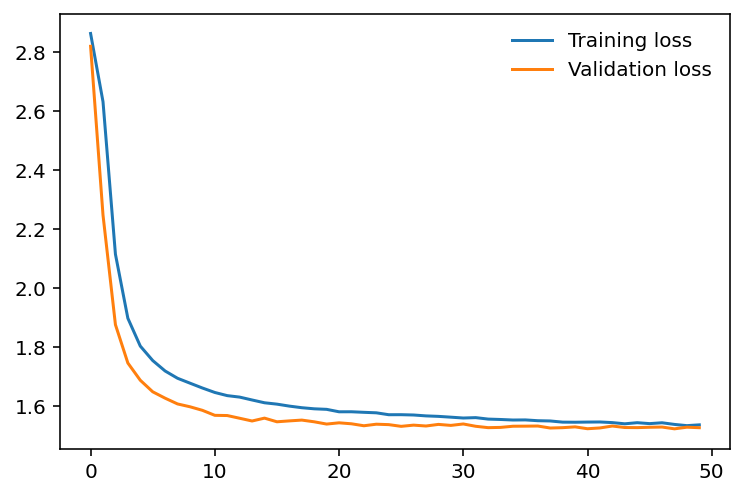

In [12]:
# plot the cost
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

## Tips: 

- Play around with the hyperparameters (Learning rate, hidden size,  drop out & epochs) until you get the accuracy you need.
- More the epoch, more the time it takes to train the data. Recommendation is to start with a smaller number and increase from there. 
- If you have cuda installed in your machine, always advisable to move the model to the cuda for a better performance.
- Use regularization, to not overfit the data.
- For local testing, try to use small epochs like 1 or 2  to start with. 


## 6. Test the trained model

- __predict__ - function which take the character as input and finds the next probable character using the previously saved model and hidden state. 
- __generate_ouput__ - function which take the text as an input and generates the next text, character by character and returns it.

In [13]:
def predict(model, char, h=None, top_k=None):
    x = np.array([[dataset.char2int[char]]])
    x = datapreprocessor.one_hot_encode(x, dataset.n_characters)
    inputs = torch.from_numpy(x).to(device)

    # detach hidden state from history
    h = tuple([each.data for each in h])
    
    #
    out, h = model(inputs, h)

    out = nn.functional.softmax(out, dim=1).data
    if torch.cuda.is_available():
        out = out.cpu()

    # get top characters
    if top_k is None:
        top_ch = np.arange(dataset.n_characters)
    else:
        out, top_ch = out.topk(top_k)
        top_ch = top_ch.numpy().squeeze()

    # select the likely next character with some element of randomness
    out = out.numpy().squeeze()
    out_char = np.random.choice(top_ch, p=out/out.sum())

    # return the encoded value of the predicted char and the hidden state
    return dataset.int2char[out_char], h

In [14]:
##generate the names
def generate_output(model, initial_str='a', predict_len=100, top_k=None):
    initial_str = datapreprocessor.unicodeToAscii(str(initial_str).lower().strip())
    
    model.eval()

    h = model.init_hidden(batch_size=1)

    input_chars = [ch for ch in initial_str]

    for ch in initial_str:
        char_out, h = predict(model, ch, h, top_k=top_k)

    input_chars.append(char_out)

    for counter in range(predict_len):
        char_out, h = predict(model, input_chars[-1], h, top_k=top_k)
        input_chars.append(char_out)

    return ''.join(input_chars)

### Loading the saved model

In [15]:
checkpoint = torch.load('char_lstm_names_generator.net')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Below is a sample call to the output function, which takes in the character or a initial str you want your name to start with and display names based on it. You can also specify the length of the output and the num of characters to be considered with the highest probability.

In [16]:
print(generate_output(model, 'ba', predict_len=100, top_k=3))

ban kumar satish kumar sahil shahid anil kumar ankaj sahil kumar ram shiv kumar ram kanhaiya rohit sing


### Try out test_reviews of your own!

- Now that you have a trained model and a predict function, you can pass in _any_ kind of text as input and this model will generate the new text based on the input.

I found the article from Andrej Karpathy very helpful.
http://karpathy.github.io/2015/05/21/rnn-effectiveness/
## Happy Learning!!!